In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import time

from numpy import typing as npt


In [2]:
def load_images(path_to_images):
    images = np.fromfile(path_to_images, dtype=np.uint8, count= -1)[16:]
    return images

def reshape_images(images):
    return images.reshape(-1, 28, 28)

def load_labels(path_to_labels):
    labels = np.fromfile(path_to_labels, dtype=np.uint8, count=-1)[8:]
    return labels

In [15]:
training_images_filepath = "/content/train-images.idx3-ubyte"
training_labels_filepath = "/content/train-labels.idx1-ubyte"

test_images_filepath = "/content/t10k-images.idx3-ubyte"
test_labels_filepath = "/content/t10k-labels.idx1-ubyte"

x_train = load_images(training_images_filepath)
x_test = load_images(test_images_filepath)

y_train = load_labels(training_labels_filepath)
y_test = load_labels(test_labels_filepath)

x_train = reshape_images(x_train)
x_test = reshape_images(x_test)

In [16]:
y_test = np.eye(10)[y_test]
y_train = np.eye(10)[y_train]

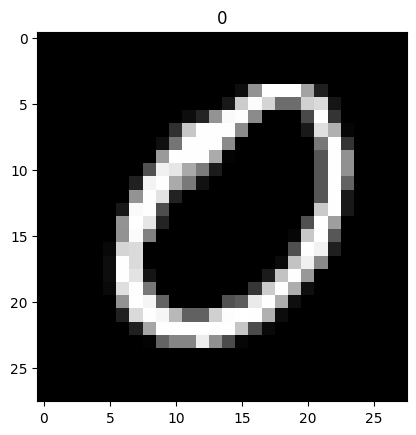

In [17]:
item_num = 1090


plt.imshow(x_train[item_num].reshape((28,28)), cmap='gray')
plt.title(f"{np.where(y_train[item_num] == 1)[0][0]}")
plt.show()

In [18]:
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

In [19]:
x_train = x_train / 255
x_test = x_test / 255

In [24]:
y_train.shape

(60000, 10)

In [20]:
class DeepNeuralNetwork():
    def __init__(
            self,
            sizes: list[int],
            epochs: int=10,
            batch_size:int=64,
            l_rate: float=0.01,
        ):
        self.sizes = sizes
        self.epochs = epochs
        self.batch_size = batch_size
        self.l_rate = l_rate

        self.params = self.initialization()

    def ReLU(
            self,
            x: npt.NDArray[np.float32],
            derivative: bool=False
    ) -> np.ndarray:

        if derivative:
            return x > 0
        return np.maximum(x, 0)

    def softmax(
            self,
            x: npt.NDArray[np.float32],
            axis: int=-1,
    ) -> npt.NDArray[np.float32]:

        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=axis, keepdims=True)

    def initialization(self) -> dict[str, npt.NDArray[np.float32]]:

        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        output_layer=self.sizes[2]

        params = {
            'W1':np.random.randn(input_layer, hidden_1) * np.sqrt(1. / hidden_1),
            'b1': np.random.randn(1, hidden_1) * np.sqrt(1. / hidden_1),

            'W2':np.random.randn(hidden_1, output_layer) * np.sqrt(1. / output_layer),
            'b2': np.random.randn(1, output_layer) * np.sqrt(1. / hidden_1),
        }

        return params

    def forward_pass(
            self,
            x_train: npt.NDArray[np.float32],
    ) -> npt.NDArray[np.float32]:

        self.params['A0'] = x_train

        self.params['Z1'] = self.params['A0'] @ self.params["W1"]  + self.params['b1']
        self.params['A1'] = self.ReLU(self.params['Z1'])

        self.params['Z2'] = self.params['A1'] @ self.params["W2"]  + self.params['b2']
        self.params['A2'] = self.softmax(self.params['Z2'])

        return self.params['A2']

    def backward_pass(
            self,
            y_train: npt.NDArray[np.float32],
            output: npt.NDArray[np.float32],
    ) -> dict[str, npt.NDArray[np.float32]]:

        change_w = {}

        dZ2 = (output - y_train)

        change_w['W2'] = (self.params['A1'].T) @ dZ2  * 1 / y_train.shape[0]
        change_w['b2'] =  np.sum(dZ2) * 1 / y_train.shape[0]

        dZ1 = 1 / y_train.shape[0] * dZ2 @ self.params['W2'].T * self.ReLU(self.params['Z1'], derivative=True)

        change_w['W1'] = self.params['A0'].T @ (dZ1)
        change_w['b1'] =  np.sum(dZ1)

        return change_w

    def update_params(self, change_w: dict[str, npt.NDArray[np.float32]]) -> None:

        self.params["W1"] -= self.l_rate * change_w['W1']
        self.params["W2"] -= self.l_rate * change_w['W2']
        self.params["b1"] -= self.l_rate * change_w['b1']
        self.params["b2"] -= self.l_rate * change_w['b2']

    def get_accuracy(
            self,
            predictions: npt.NDArray[np.float32],
            Y: npt.NDArray[np.float32]
    ) -> float:

        return np.sum(predictions == Y) / Y.size

    def train(
            self,
            x_train: npt.NDArray[np.float32],
            y_train: npt.NDArray[np.float32],
            x_val: npt.NDArray[np.float32],
            y_val: npt.NDArray[np.float32],
    ) -> None:

        start_time = time.time()
        num_batch_per_ephoc = x_train.shape[0] // self.batch_size

        if num_batch_per_ephoc != x_train.shape[0] / self.batch_size:
            num_batch_per_ephoc += 1

        for iteration in range(self.epochs):
            output_accum = []
            for batch_number in range(num_batch_per_ephoc):

                x_curr = x_train[self.batch_size * batch_number : self.batch_size * (batch_number+1)]
                y_curr = y_train[self.batch_size * batch_number : self.batch_size * (batch_number+1)]

                output = self.forward_pass(x_curr)
                output_accum.extend(np.argmax(output, axis= 1))

                changes = self.backward_pass(y_curr, output)

                self.update_params(changes)

            accuracy = self.get_accuracy(np.array(output_accum), np.argmax(y_train, axis= 1))

            print(f'Epoch: {iteration+1}, Time Spent: {time.time() - start_time:.2f}s, Train accuracy: {accuracy:.3f}')

        preds_val = self.forward_pass(x_val)

        print(f"\nTest accuracy: {self.get_accuracy(np.argmax(preds_val , axis= 1), np.argmax(y_val, axis= 1)):.3f}")

In [26]:
dnn = DeepNeuralNetwork(sizes=[784, 300, 10], epochs=20, batch_size=64, l_rate=0.1)
dnn.train(x_train, y_train, x_test, y_test)

Epoch: 1, Time Spent: 5.56s, Train accuracy: 0.927
Epoch: 2, Time Spent: 9.52s, Train accuracy: 0.967
Epoch: 3, Time Spent: 12.64s, Train accuracy: 0.976
Epoch: 4, Time Spent: 15.92s, Train accuracy: 0.982
Epoch: 5, Time Spent: 21.26s, Train accuracy: 0.986
Epoch: 6, Time Spent: 24.34s, Train accuracy: 0.989
Epoch: 7, Time Spent: 27.47s, Train accuracy: 0.991
Epoch: 8, Time Spent: 31.40s, Train accuracy: 0.993
Epoch: 9, Time Spent: 36.04s, Train accuracy: 0.995
Epoch: 10, Time Spent: 39.18s, Train accuracy: 0.996
Epoch: 11, Time Spent: 42.30s, Train accuracy: 0.997
Epoch: 12, Time Spent: 47.09s, Train accuracy: 0.997
Epoch: 13, Time Spent: 50.72s, Train accuracy: 0.998
Epoch: 14, Time Spent: 53.90s, Train accuracy: 0.999
Epoch: 15, Time Spent: 57.01s, Train accuracy: 0.999
Epoch: 16, Time Spent: 62.35s, Train accuracy: 0.999
Epoch: 17, Time Spent: 65.44s, Train accuracy: 0.999
Epoch: 18, Time Spent: 68.56s, Train accuracy: 0.999
Epoch: 19, Time Spent: 73.70s, Train accuracy: 0.999
Epoc